In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import math

In [ ]:
def generate_random_dataset(elements, groups):
  """
  Se generan numeros aleatorios entre 0 y 5000 para crear un data set diferenciando entre 4 grupos.
  1: hombres mayores 40, 2: mujeres mayores 40, 3 hombres menores 40 y 4 mujeres menores 40.

  """
  random_numbers = np.sort(np.random.randint(0, elements, groups-1)) # Se hace hasta 5001 para incluir el 5000

  n_zeros = random_numbers[0]
  n_ones = random_numbers[1] - n_zeros
  n_twos = random_numbers[2] - n_ones - n_zeros
  n_threes = elements - n_twos - n_ones - n_zeros
  dataset = np.array([0] * n_zeros + [1] * n_ones + [2] * n_twos + [3] * n_threes)
  np.random.shuffle(dataset)
  
  return dataset

In [ ]:
def generate_list_datasets(numdatasets, elements, groups):
  """
  Se generan numdatasets para analizar los resultados con varios datasets con distintas cantidades de los grupos.
  """
  listdatasets = []
  for i in range(numdatasets):
    listdatasets.append(generate_random_dataset(elements, groups))
  return listdatasets

In [ ]:
def generate_random_probabilities(num_probabilities):
  """
  Genera num_probabilities aleatorias para cada pelicula: Son 3, primera si gusta mucho, segunda si gusta poco y
  tercera si no gusta.
  """
  random_probs = np.random.rand(num_probabilities - 1)
  random_probs = np.sort(np.concatenate(([0], random_probs, [1])))
  return np.diff(random_probs)

In [ ]:
def generate_movie_probabilities(num_movies, num_groups):
  """
  Obtiene las probabilidades de cada grupo (num_groups) para cada pelicula (num_movies) 
  """
  probabilities = {}
  num_probabilities = 3
  for group in range(num_groups):
      group_probabilities = []
      for movie in range(num_movies):
          movie_probabilities = generate_random_probabilities(num_probabilities)
          group_probabilities.append(movie_probabilities)
      probabilities[group] = group_probabilities

  
  return probabilities

In [ ]:
class UCB1:
  """
  Implementación del algoritmo UCB1.
  """
  def __init__(self, num_arms):
      self.counts = np.zeros(num_arms)  # selecciones de cada brazo
      self.values = np.zeros(num_arms)  # media brazo

  def select_arm(self):
      n_total = sum(self.counts)
      if n_total == 0:
          return np.random.randint(len(self.counts)) # si no se había seleccionado ningún brazo
      
      term = 1e-5
      explore_rate = 2 * np.log(n_total) / (self.counts + term) # 2 logT/n + cuanto mayor explora mas
      ucb_values = self.values + np.sqrt(explore_rate) # se calcula ucb y se elige aquel con mayor ucb
      return np.argmax(ucb_values)

  def update(self, arm, reward):
      self.counts[arm] += 1
      self.values[arm] = ((self.counts[arm] - 1) * self.values[arm] + reward) / self.counts[arm]


In [ ]:
def reward_function(movie_probabilities, context, arm):
    probs = movie_probabilities[context][arm]
    return np.random.choice([5, 3, 0], p=probs)

In [ ]:
def plot_group_percentages(datasets, num_groups):
    num_datasets = len(datasets)
    group_percentages = np.zeros((num_datasets, num_groups))

    for i, dataset in enumerate(datasets):
        group_counts = np.bincount(dataset, minlength=num_groups)
        group_percentages[i] = group_counts / len(dataset) * 100

    x = np.arange(num_datasets)
    bar_width = 0.2

    fig, ax = plt.subplots()
    for group in range(num_groups):
        ax.bar(x + bar_width * group, group_percentages[:, group], width=bar_width, label=f'Grupo {group}')

    ax.set_xticks(x + bar_width * (num_groups - 1) / 2)
    ax.set_xlabel('Distribuciones de usuarios')
    ax.set_ylabel('Porcentaje del grupo (%)')
    ax.legend()

    plt.show()


In [ ]:
def simulate_contextual_bandits(T, num_datasets, num_movies, num_groups):
    datasets = generate_list_datasets(num_datasets, T, num_groups)
    dsize = len(datasets)
    i = 0
    total_reward = np.zeros(dsize)
    total_loss = np.zeros(dsize)
    total_rewardUCB = np.zeros(dsize)
    total_lossUCB = np.zeros(dsize)
    K = 5
    movie_probabilities = generate_movie_probabilities(num_movies, num_groups)

    for data in datasets:
      instances = [UCB1(K) for _ in range(num_groups)]
      instanceUCB = UCB1(K)

      for t in range(T):
        context = data[t]

        alg = instances[context]
        arm = alg.select_arm()
        contextualreward = (reward_function(movie_probabilities, context, arm)) / 5
        alg.update(arm, contextualreward)
        total_reward[i] += contextualreward
        total_loss[i] += (1- contextualreward)

        alg2 = instanceUCB
        arm2 = alg2.select_arm()
        reward = (reward_function(movie_probabilities, context, arm2)) / 5
        alg2.update(arm2, reward)        
        total_rewardUCB[i] += reward
        total_lossUCB[i] += (1- reward)
      i = i + 1
    return total_reward, total_loss, total_rewardUCB, total_lossUCB

In [ ]:
def plot_rewards_and_losses(total_reward, total_loss, total_rewardUCB, total_lossUCB, num_datasets):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_datasets + 1), total_reward, label="Bandido Contextual", color="#1f77b4", linewidth=2)
    plt.plot(range(1, num_datasets + 1), total_rewardUCB, label="UCB1", color="#7f7f7f", linewidth=2, linestyle="--")
    plt.xlabel("Número de bases de datos")
    plt.ylabel("Recompensas")
    plt.legend(loc="upper left")
    plt.title("Recompensas por cada base de datos")
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_datasets + 1), total_loss, label="Bandido Contextual", color="#1f77b4", linewidth=2)
    plt.plot(range(1, num_datasets + 1), total_lossUCB, label="UCB1", color="#7f7f7f", linewidth=2, linestyle="--")
    plt.xlabel("Número de bases de datos")
    plt.ylabel("Remoridimientos")
    plt.legend(loc="upper left")
    plt.title("Remordimientos por cada base de datos")
    plt.grid()

    plt.tight_layout()
    plt.show()


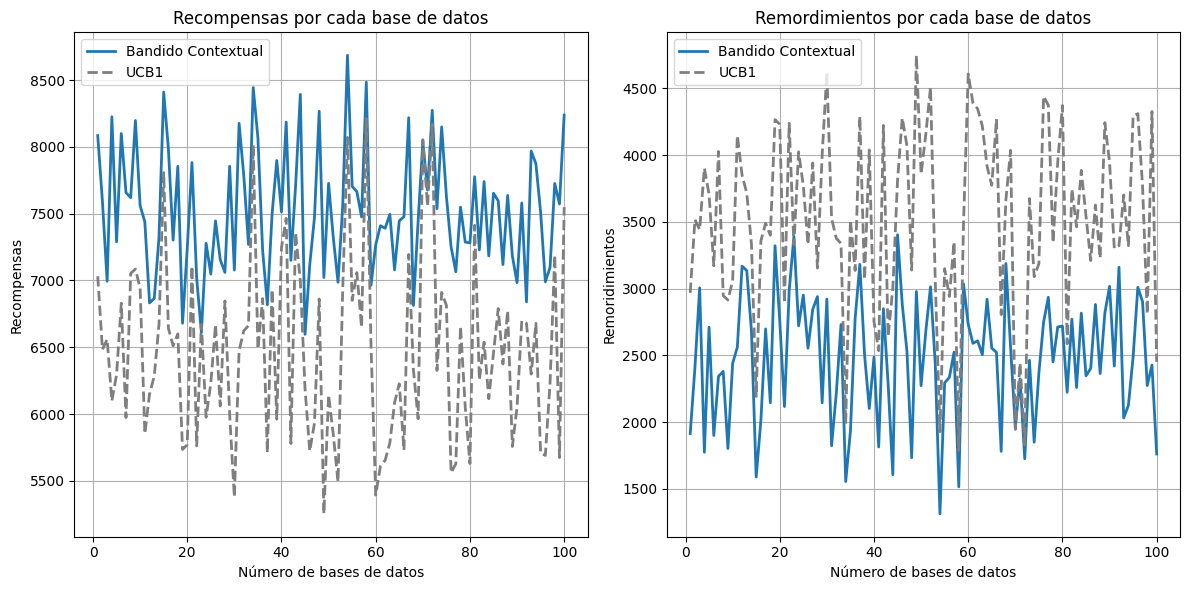

In [ ]:
T = 10000 # probar con distintos tamaños

num_datasets = 100
num_movies = 5
num_groups = 4

total_reward, total_loss, total_rewardUCB, total_lossUCB = simulate_contextual_bandits(T, num_datasets, num_movies, num_groups)

plot_rewards_and_losses(total_reward, total_loss, total_rewardUCB, total_lossUCB, num_datasets)





In [ ]:
def simulate_contextual_banditsLearn(T, num_movies, num_groups):
    data = generate_random_dataset(T, num_groups)
  
    K = num_movies
    movie_probabilities = generate_movie_probabilities(num_movies, num_groups)

    total_reward = np.zeros(len(data))
    total_loss = np.zeros(len(data))
    total_rewardUCB = np.zeros(len(data))
    total_lossUCB = np.zeros(len(data))
    instances = [UCB1(K) for _ in range(num_groups)]
    instanceUCB = UCB1(K)

    for i in range(T):
      context = data[i]

      alg = instances[context]
      arm = alg.select_arm()
      contextualreward = (reward_function(movie_probabilities, context, arm)) / 5
      alg.update(arm, contextualreward)
      total_reward[i] = contextualreward
      total_loss[i] = (1- contextualreward)

      alg2 = instanceUCB
      arm2 = alg2.select_arm()
      reward = (reward_function(movie_probabilities, context, arm2)) / 5
      alg2.update(arm2, reward)        
      total_rewardUCB[i] = reward
      total_lossUCB[i] = (1- reward)
    return total_reward, total_loss, total_rewardUCB, total_lossUCB

In [ ]:
def plot_rewards_and_lossesLearn(total_reward, total_loss, total_rewardUCB, total_lossUCB, T):
    plt.figure(figsize=(12, 6))
    
    avg_reward = np.cumsum(total_reward) / np.arange(1, T + 1)
    avg_rewardUCB = np.cumsum(total_rewardUCB) / np.arange(1, T + 1)
    avg_loss = np.cumsum(total_loss) / np.arange(1, T + 1)
    avg_lossUCB = np.cumsum(total_lossUCB) / np.arange(1, T + 1)
    
    plt.subplot(1, 2, 1)
    plt.plot(range(T), avg_reward, label='Bandido Contextual')
    plt.plot(range(T), avg_rewardUCB, label='UCB1')
    plt.xlabel('Número de usuarios')
    plt.ylabel('Recompensas')
    plt.title('Comparación de recompensas obtenidas')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(range(T), avg_loss, label='Bandido contextual')
    plt.plot(range(T), avg_lossUCB, label='UCB1')
    plt.xlabel('Número de usuarios')
    plt.ylabel('Remordimiento')
    plt.title('Comparación de remordimientos obtenidos')
    plt.legend()
    
    plt.show()

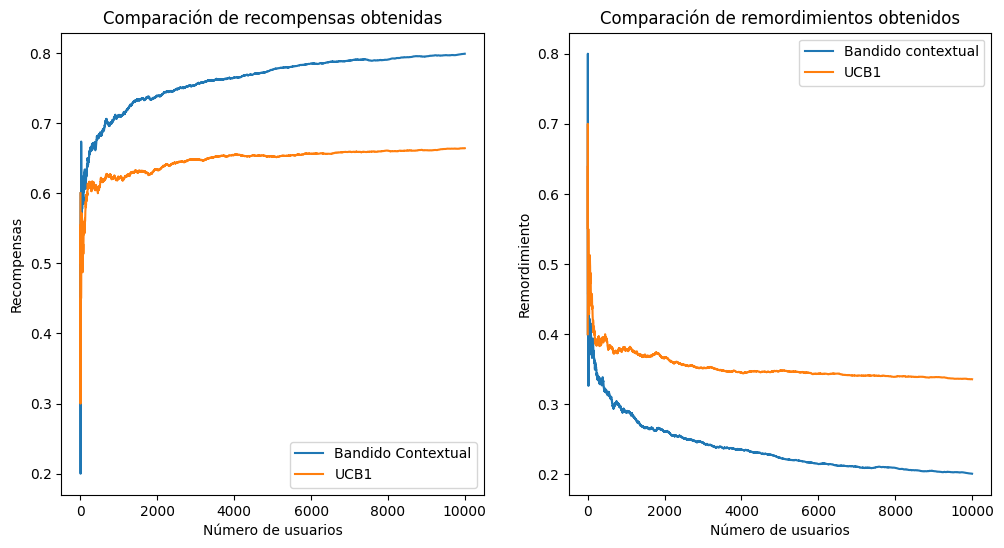

In [ ]:
T = 10000 
num_movies = 5
num_groups = 4

total_reward, total_loss, total_rewardUCB, total_lossUCB = simulate_contextual_banditsLearn(T, num_movies, num_groups)

plot_rewards_and_lossesLearn(total_reward, total_loss, total_rewardUCB, total_lossUCB, T)
